## Standard NASCAR data  
Multiple fits for error band.

In [1]:
from bbvi_infer_2l import * 
from nascarsoft import *
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mean_std_rounded(values):
    values = np.array(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # sample std deviation

    # Round both to 2 decimal places
    mean_rounded = round(mean, 2)
    std_rounded = round(std, 2)

    return f"{mean_rounded} ± {std_rounded}"

### Generate soft sticky observations

In [3]:
K=4 ## state
D=2 ## latent dimension
T=1000 ## timesteps

In [4]:
zs_train, xs_train, ys_train, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.01, 
                                     scale=1, speed=1, fancy=True, gamma=0)
zs_test, xs_test, ys_test, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.01, 
                                     scale=1, speed=1, fancy=True, gamma=0, emission=C)

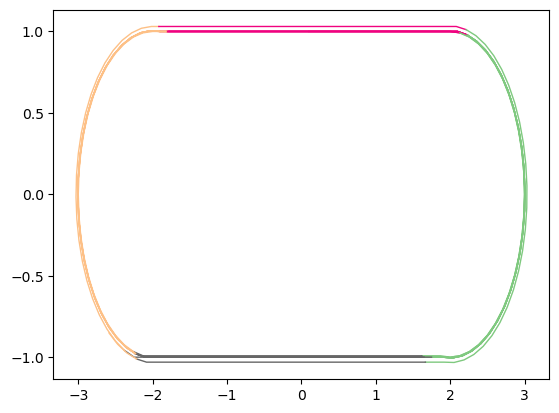

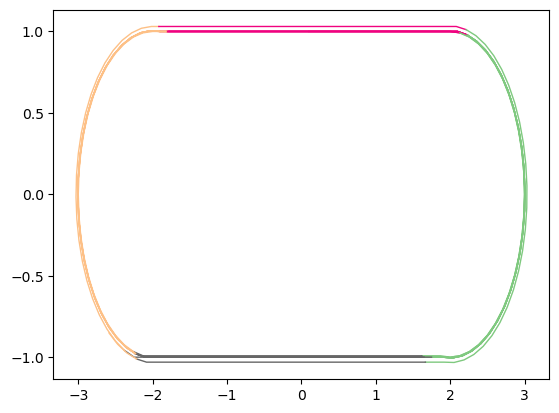

In [5]:
plot_trajectory(np.argmax(zs_train, axis=1), xs_train, ls="-")
plot_trajectory(np.argmax(zs_test, axis=1), xs_test, ls="-")

## GDM 
### GDM Train

In [6]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    torch.manual_seed(42+seed)  # Set PyTorch seed
    torch.cuda.manual_seed_all(seed)  # Set CUDA seed 

    model = GenerativeSLDS(N=10, K=4, D=2, emission_model="gaussian")
    elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), ys = torch.tensor(ys_train).to('cuda').float(), 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, verbose=False)
    ## train
    zs = variational_z.sample_q_z(torch.tensor(ys_train).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
    pred_ys0=model.smooth(torch.tensor(ys_train).to('cuda').float(), zs).mean(dim=0).detach().cpu().numpy() # [T, N]
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    trains.append(train_r2)
    print("Train accuracy:", train_r2)
    
    ## test
    zs2 = variational_z.sample_q_z(torch.tensor(ys_test).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
    pred_ys2=model.smooth(torch.tensor(ys_test).to('cuda').float(), zs2).mean(dim=0).detach().cpu().numpy() # [T, N]
    y_preds, z_preds = predict_k_step_more(k_max=10, model=model, variational_z=variational_z, ys=ys_train)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    
    ## state quality
    Z_train = torch.mean(zs, dim=0).detach().cpu().numpy()
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = torch.mean(zs2, dim=0).detach().cpu().numpy()
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print("Test state quality:", acc)

ELBO: -6697.9, LR: 0.01000, Tau: 0.990:   5%|▍         | 198/4000 [00:02<00:41, 92.03it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 15114.6, LR: 0.00100, Tau: 0.990:  66%|██████▌   | 2630/4000 [00:27<00:14, 95.43it/s]


Early stopping at iteration 2630.
Train accuracy: [0.998637746614307]
Test accuracy: 0.9986352422956163 -1.1841378731297174
Test state quality: 0.899


ELBO: -4383.4, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:38, 97.83it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 18790.2, LR: 0.00100, Tau: 0.990:  92%|█████████▏| 3677/4000 [00:38<00:03, 95.11it/s]


Early stopping at iteration 3677.
Train accuracy: [0.9997532437203238]
Test accuracy: 0.9997509885005391 0.9910435956630874
Test state quality: 0.941


ELBO: -1368.1, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.87it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 21804.9, LR: 0.00100, Tau: 0.990: 100%|██████████| 4000/4000 [00:41<00:00, 96.10it/s]


Train accuracy: [0.9998566115675876]
Test accuracy: 0.9998571917366441 0.9973236213339712
Test state quality: 0.896


ELBO: -3748.6, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.49it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 18784.8, LR: 0.00100, Tau: 0.990:  79%|███████▊  | 3145/4000 [00:33<00:08, 95.06it/s]


Early stopping at iteration 3145.
Train accuracy: [0.9998298518520402]
Test accuracy: 0.9998247824503907 0.9977526061988218
Test state quality: 0.948


ELBO: -5967.3, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.27it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 19829.0, LR: 0.00100, Tau: 0.990: 100%|██████████| 4000/4000 [00:42<00:00, 95.05it/s]


Train accuracy: [0.9995778805105526]
Test accuracy: 0.9995663217152349 0.8189737206571047
Test state quality: 0.963


ELBO: -6134.3, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.45it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 748.6, LR: 0.00100, Tau: 0.990:  16%|█▋        | 660/4000 [00:06<00:34, 95.53it/s]  


Early stopping at iteration 660.
Train accuracy: [0.9960316133548904]
Test accuracy: 0.9957813938439276 -0.01593143724070355
Test state quality: 0.894


ELBO: -3731.2, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.45it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 15210.8, LR: 0.00100, Tau: 0.990:  76%|███████▌  | 3023/4000 [00:31<00:10, 96.21it/s]


Early stopping at iteration 3023.
Train accuracy: [0.9964003609018685]
Test accuracy: 0.9964117060481377 0.6620148240199655
Test state quality: 0.961


ELBO: -4112.9, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 96.12it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 16028.7, LR: 0.00100, Tau: 0.990:  63%|██████▎   | 2522/4000 [00:26<00:15, 94.55it/s]


Early stopping at iteration 2522.
Train accuracy: [0.999721948967986]
Test accuracy: 0.9997225334010817 0.9876116496024177
Test state quality: 0.902


ELBO: -8020.4, LR: 0.01000, Tau: 0.990:   5%|▍         | 199/4000 [00:02<00:40, 94.68it/s] /opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 9935.6, LR: 0.00100, Tau: 0.990:  67%|██████▋   | 2676/4000 [00:28<00:13, 95.08it/s] 


Early stopping at iteration 2676.
Train accuracy: [0.9926684357403213]
Test accuracy: 0.9925041992819128 -28.895124898467692
Test state quality: 0.8


ELBO: -12018.7, LR: 0.01000, Tau: 0.990:   5%|▍         | 190/4000 [00:02<00:39, 95.73it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: 5780.5, LR: 0.00100, Tau: 0.990:  82%|████████▏ | 3285/4000 [00:34<00:07, 94.74it/s] 


Early stopping at iteration 3285.
Train accuracy: [0.9778748318549588]
Test accuracy: 0.9779148040159267 -6344.25233716496
Test state quality: 0.617


In [8]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.88 ± 0.1', '1.0 ± 0.01', '1.0 ± 0.01', '-636.89 ± 2005.38')

## Benchmarks
### Sticky Recurrent SLDS Train

In [9]:
import ssm
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

In [10]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[np.arange(T - 1), z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

ELBO: 23360.0: 100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


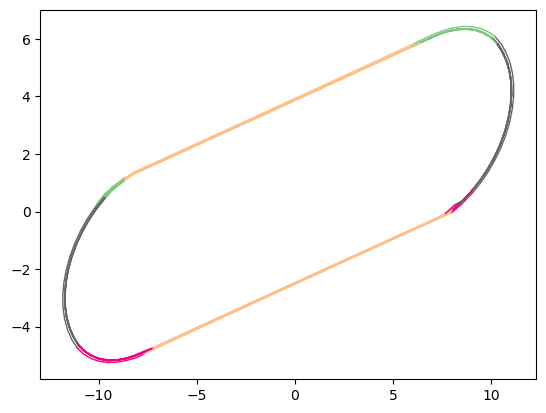

Train accuracy: [0.999960108444993]
Test accuracy: 0.9999579254208513 0.9743001445307428
Silhouette score at 4 states: 0.05462251496012798
State quality for 4 states: 0.687


ELBO: 23760.5: 100%|██████████| 100/100 [00:13<00:00,  7.59it/s]


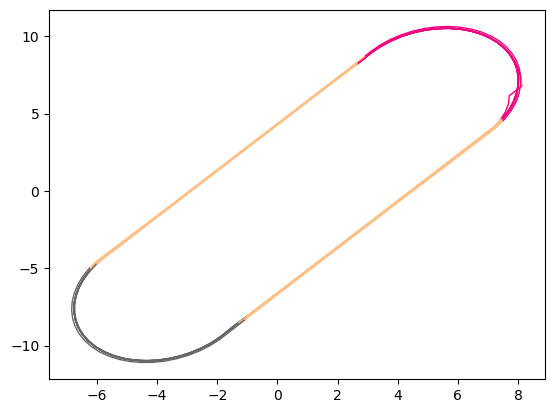

Train accuracy: [0.9999609781203246]
Test accuracy: 0.999960363704564 0.9997903969511845
Silhouette score at 4 states: 0.37780555908175234
State quality for 4 states: 0.836


ELBO: 23301.4: 100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


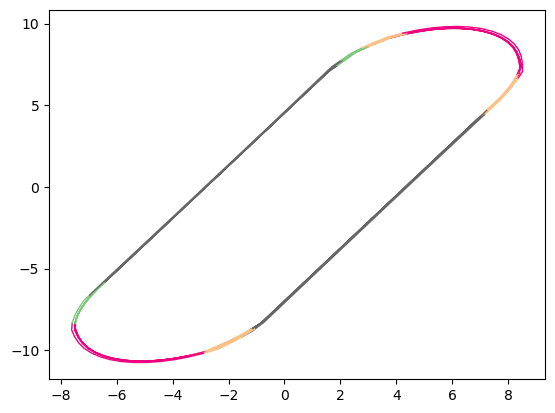

Train accuracy: [0.9999549796555444]
Test accuracy: 0.9999535830908316 0.9663198774140733
Silhouette score at 4 states: 0.0778971716625445
State quality for 4 states: 0.652


ELBO: 23550.3: 100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


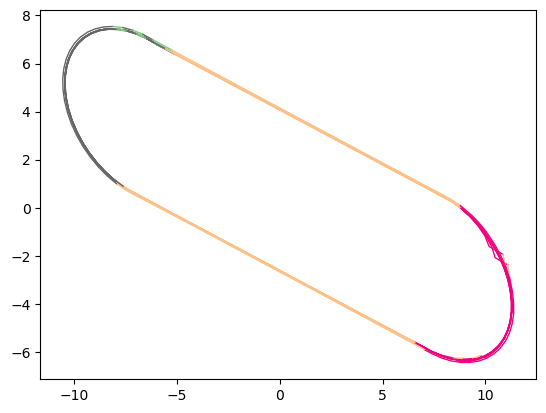

Train accuracy: [0.9999579210895078]
Test accuracy: 0.9999572451163956 0.9993754394885338
Silhouette score at 4 states: 0.22063404149548346
State quality for 4 states: 0.834


ELBO: 23793.6: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


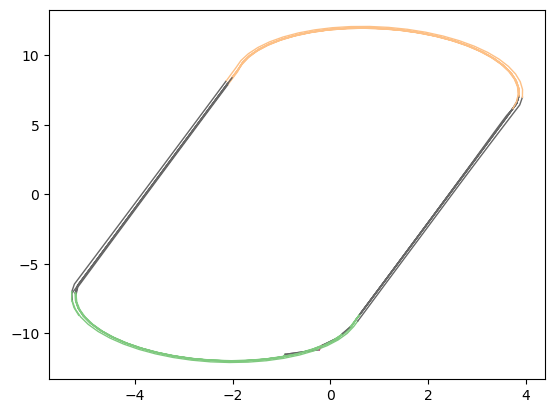

Train accuracy: [0.9999588976457698]
Test accuracy: 0.9999583645721783 0.9998573274174405
Silhouette score at 4 states: 0.18191259546175248
State quality for 4 states: 0.831


ELBO: 24102.5: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


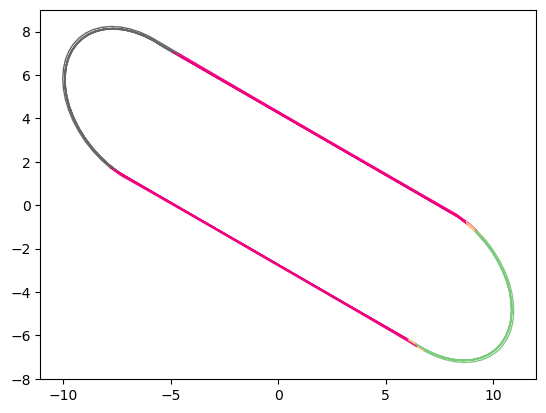

Train accuracy: [0.9999632674983229]
Test accuracy: 0.9999630644388093 0.9998983550977197
Silhouette score at 4 states: 0.24127380936283047
State quality for 4 states: 0.839


ELBO: 24022.1: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


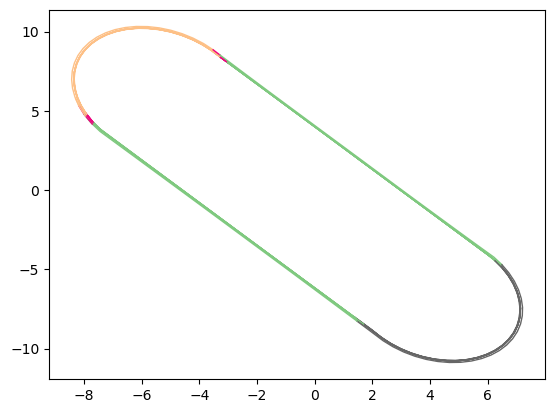

Train accuracy: [0.9999632117655471]
Test accuracy: 0.9999629707609557 0.9996645461462397
Silhouette score at 4 states: 0.24128881236313
State quality for 4 states: 0.839


ELBO: 23462.7: 100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


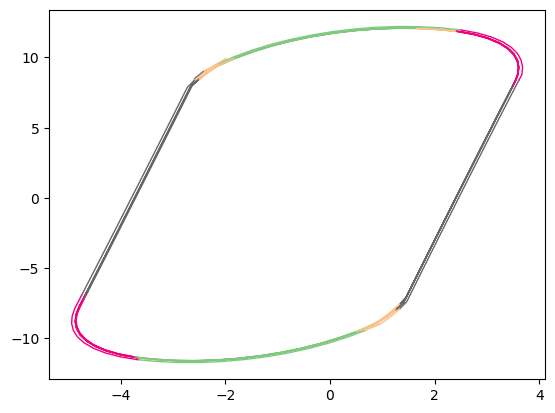

Train accuracy: [0.9999582671230997]
Test accuracy: 0.9999564887778447 0.9701541013276916
Silhouette score at 4 states: 0.17163805362700646
State quality for 4 states: 0.611


ELBO: 22823.5: 100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


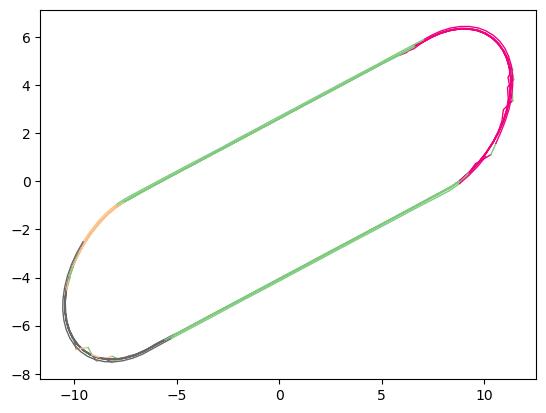

Train accuracy: [0.9999530561836011]
Test accuracy: 0.9999507166616798 0.9996068970499034
Silhouette score at 4 states: 0.227935820141276
State quality for 4 states: 0.826


ELBO: 23062.8: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


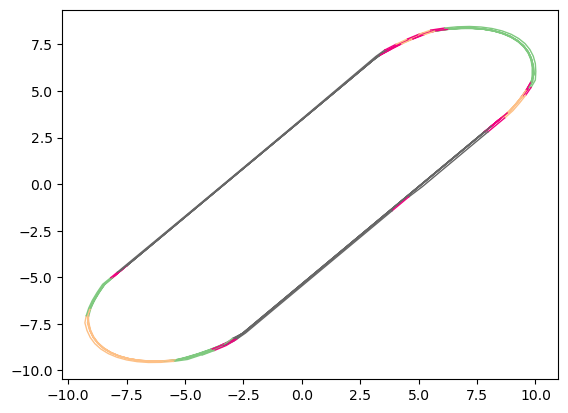

Train accuracy: [0.9999522060079755]
Test accuracy: 0.9999513127443557 0.9684386045938647
Silhouette score at 4 states: 0.13337338990045505
State quality for 4 states: 0.622


In [11]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions=sro_trans,
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [12]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.76 ± 0.1', '1.0 ± 0.0', '1.0 ± 0.0', '0.99 ± 0.02')

### Recurrent Only rSLDS Train

ELBO: 23530.4: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


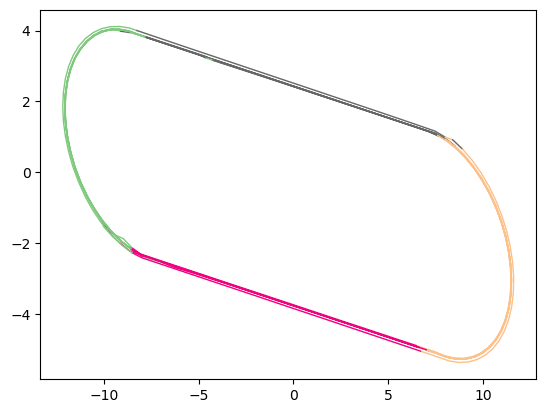

Train accuracy: [0.9999628401101456]
Test accuracy: 0.9999612210978533 0.9998118617629123
Silhouette score at 4 states: 0.4186008044901063
State quality for 4 states: 0.99


ELBO: 23356.3: 100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


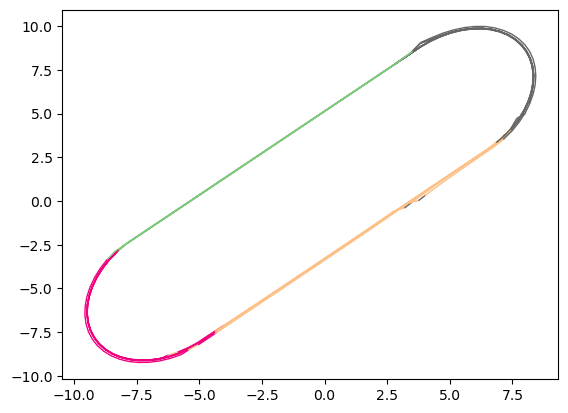

Train accuracy: [0.9999508968224102]
Test accuracy: 0.9999483681527263 0.9998092952399004
Silhouette score at 4 states: 0.40820054808875533
State quality for 4 states: 0.979


ELBO: 23398.0: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


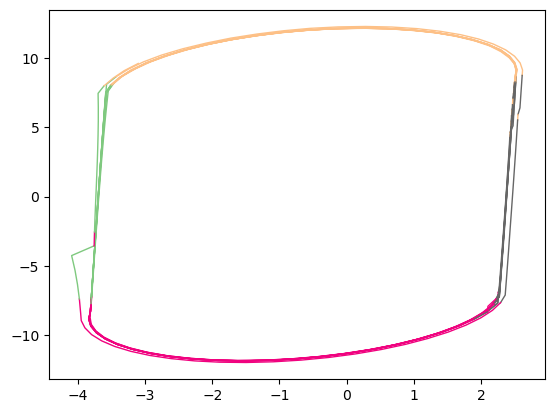

Train accuracy: [0.9999593373453133]
Test accuracy: 0.999957117404837 0.9994135079050828
Silhouette score at 4 states: 0.420171724125542
State quality for 4 states: 0.987


ELBO: 23155.5: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s]


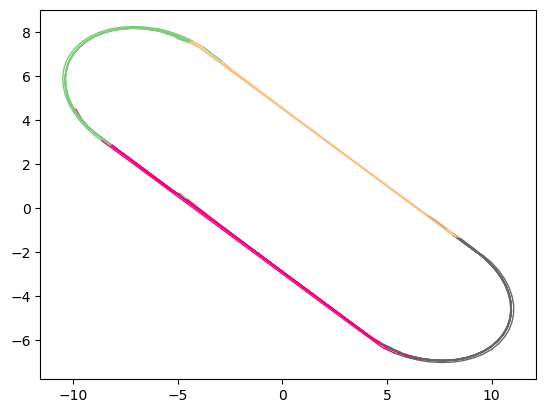

Train accuracy: [0.9999564638841315]
Test accuracy: 0.9999540099983795 0.9994433972496912
Silhouette score at 4 states: 0.4120783090543957
State quality for 4 states: 0.984


ELBO: 23072.3: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


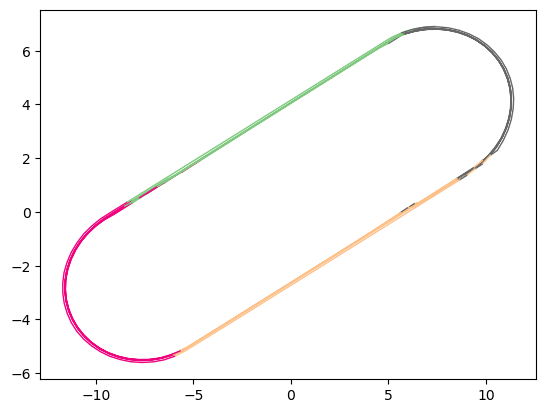

Train accuracy: [0.9999608577719549]
Test accuracy: 0.9999584738425487 0.9997083989964898
Silhouette score at 4 states: 0.41441122606991176
State quality for 4 states: 0.979


ELBO: 24114.4: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


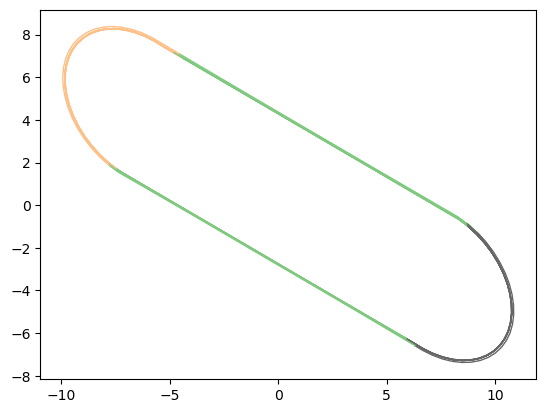

Train accuracy: [0.9999633500754512]
Test accuracy: 0.9999630499455338 0.9999242193920198
Silhouette score at 4 states: 0.37712407513702406
State quality for 4 states: 0.838


ELBO: 23700.7: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


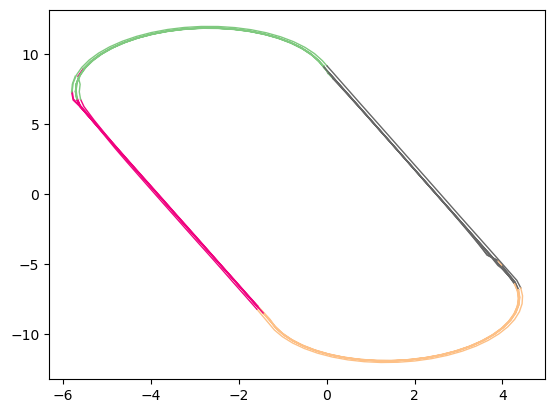

Train accuracy: [0.9999613677992487]
Test accuracy: 0.9999603645341255 0.99774561653289
Silhouette score at 4 states: 0.4208164265491742
State quality for 4 states: 0.99


ELBO: 23195.1: 100%|██████████| 100/100 [00:11<00:00,  8.84it/s]


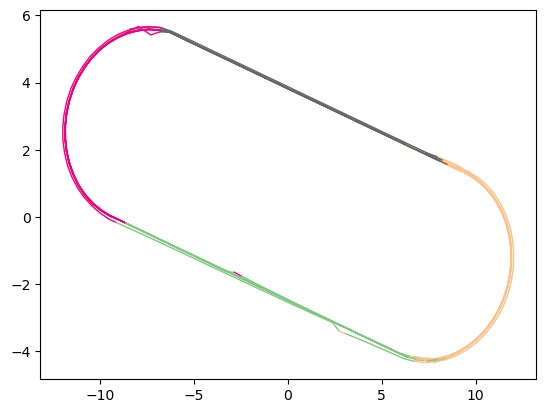

Train accuracy: [0.9999579015193539]
Test accuracy: 0.9999557139150278 0.9998216041595323
Silhouette score at 4 states: 0.41575274028098796
State quality for 4 states: 0.988


ELBO: 23876.2: 100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


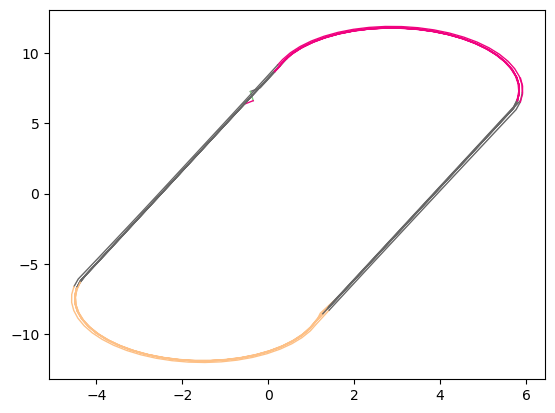

Train accuracy: [0.9999612268993809]
Test accuracy: 0.9999600025160283 0.9998725018726461
Silhouette score at 4 states: 0.28220993322242177
State quality for 4 states: 0.833


ELBO: 23352.6: 100%|██████████| 100/100 [00:11<00:00,  8.76it/s]


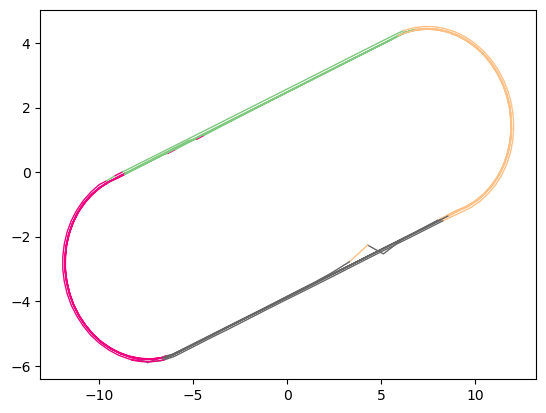

Train accuracy: [0.9999586280595283]
Test accuracy: 0.9999574158006659 0.9998156005461647
Silhouette score at 4 states: 0.4222070142776316
State quality for 4 states: 0.989


In [11]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [12]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.96 ± 0.06', '1.0 ± 0.0', '1.0 ± 0.0', '1.0 ± 0.0')

### SLDS Train

In [13]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[0,z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

ELBO: 23418.8: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


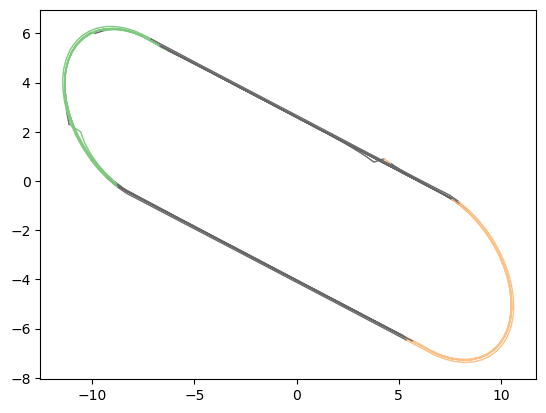

Train accuracy: [0.9999591623046495]
Test accuracy: 0.999958263606181 0.9701903682288607
Silhouette score at 4 states: 0.37256786837845834
State quality for 4 states: 0.834


ELBO: 23897.5: 100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


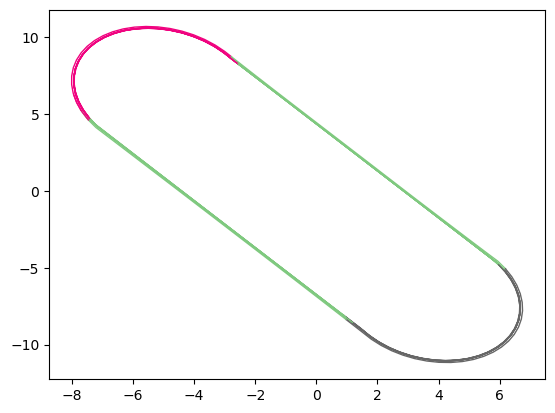

Train accuracy: [0.9999634148000671]
Test accuracy: 0.9999631731398235 0.9705910732897541
Silhouette score at 4 states: 0.3780259121665281
State quality for 4 states: 0.839


ELBO: 23034.9: 100%|██████████| 100/100 [00:08<00:00, 12.28it/s]


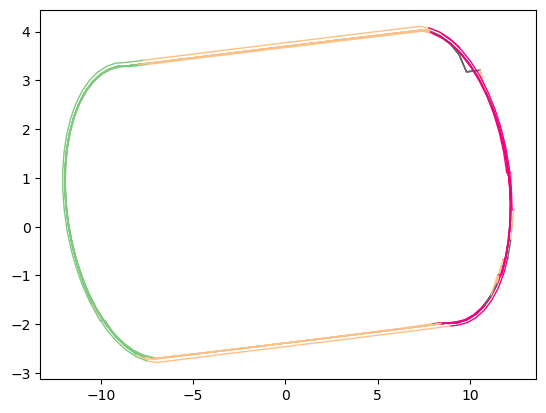

Train accuracy: [0.9999437194360066]
Test accuracy: 0.9999423973340844 0.9664099166685356
Silhouette score at 4 states: 0.21690507799964556
State quality for 4 states: 0.827


ELBO: 23570.5: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


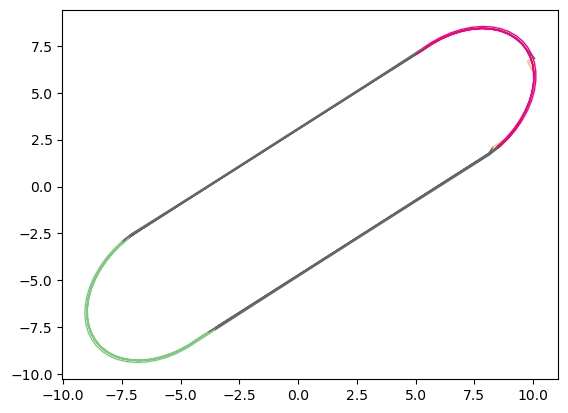

Train accuracy: [0.9999571463142889]
Test accuracy: 0.9999564743358575 0.955915389169796
Silhouette score at 4 states: 0.2243365876381679
State quality for 4 states: 0.836


ELBO: 23183.8: 100%|██████████| 100/100 [00:08<00:00, 12.15it/s]


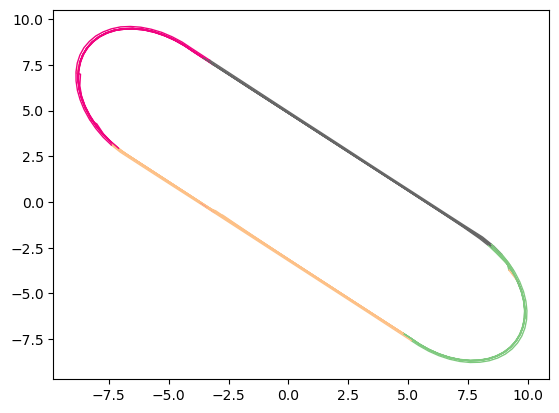

Train accuracy: [0.999958333372636]
Test accuracy: 0.9999570241866745 0.972426469303634
Silhouette score at 4 states: 0.4134862573501782
State quality for 4 states: 0.993


ELBO: 23943.4: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


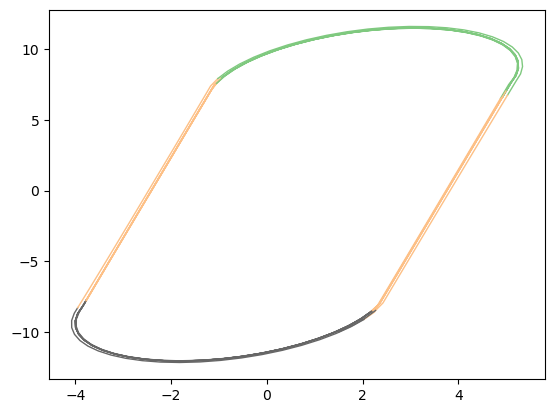

Train accuracy: [0.9999645743516401]
Test accuracy: 0.9999644303575821 0.9705809912755452
Silhouette score at 4 states: 0.37815716415203615
State quality for 4 states: 0.839


ELBO: 23523.5: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


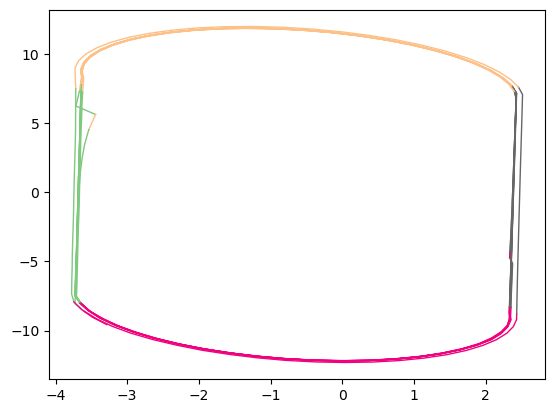

Train accuracy: [0.9999627033392068]
Test accuracy: 0.999961178588214 0.9707680591483318
Silhouette score at 4 states: 0.4242317571377829
State quality for 4 states: 0.996


ELBO: 23641.3: 100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


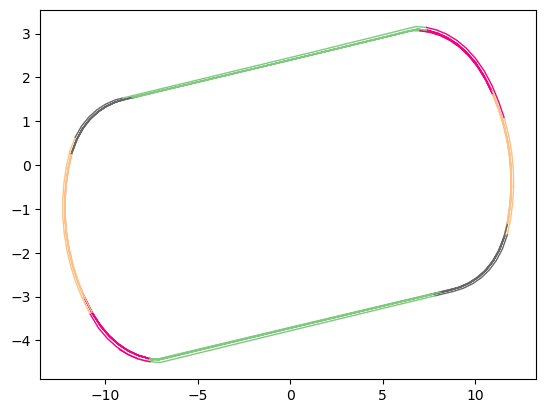

Train accuracy: [0.9999574279007559]
Test accuracy: 0.9999574761237604 0.9686450723366233
Silhouette score at 4 states: 0.17864097710672025
State quality for 4 states: 0.621


ELBO: 23296.6: 100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


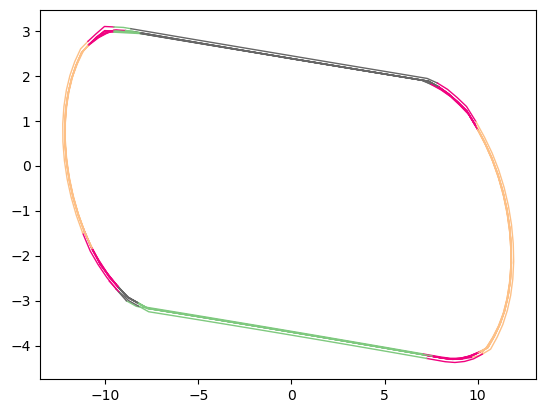

Train accuracy: [0.9999590481512384]
Test accuracy: 0.9999580981403271 0.9648980630477411
Silhouette score at 4 states: 0.13390535525739558
State quality for 4 states: 0.754


ELBO: 23620.2: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


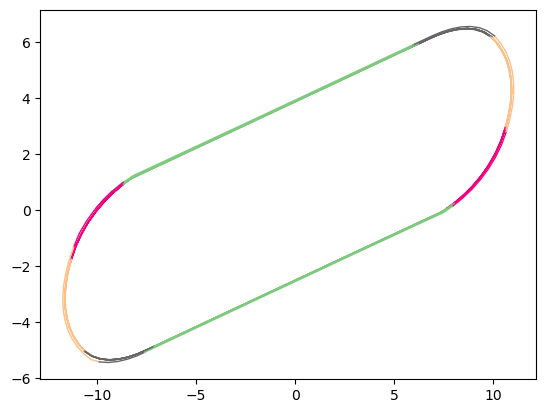

Train accuracy: [0.9999560865914539]
Test accuracy: 0.9999563107514001 0.9687193650694876
Silhouette score at 4 states: 0.1793232675379731
State quality for 4 states: 0.621


In [14]:
trains = []
tests0 = []
tests100 = []
statesq = []
for seed in range(10):  ## repeat tests
    rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="sticky",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
    rslds.initialize(ys_train)
    q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
    q_lem_x = q_lem.mean_continuous_states[0]
    q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
    plot_trajectory(q_lem_z, q_lem_x)
    pred_ys0=rslds.smooth(q_lem_x, ys_train)
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    print("Train accuracy:", train_r2)
    trains.append(train_r2)
    ## no retrain allowed
    pred_ys2=rslds.smooth(q_lem_x, ys_test)
    y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_test, k=10)
    test_r2 = train_metrics(ys_test, pred_ys2, y_preds, k_max=10)
    tests0.append(test_r2[0])
    tests100.append(test_r2[-1])
    print("Test accuracy:", test_r2[0], test_r2[-1])
    sil = silhouette_score(q_lem_x, q_lem_z)
    print(f"Silhouette score at {K} states:", sil)
    
    Z_train = np.eye(K)[q_lem_z]
    Y_train = np.array(zs_train.argmax(axis=1))
    Z_test = np.eye(K)[q_lem_z]
    Y_test = np.array(zs_test.argmax(axis=1))
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print(f"State quality for {K} states:", acc)

In [15]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests0),mean_std_rounded(tests100)

('0.82 ± 0.13', '1.0 ± 0.0', '1.0 ± 0.0', '0.97 ± 0.0')

### p-dLDS Train

In [6]:
from pdLDS import pdLDS

In [7]:
trains = []
tests = []
statesq = []
for seed in range(10):  ## repeat tests
    torch.manual_seed(seed)  # Set PyTorch seed
    torch.cuda.manual_seed_all(seed)  # Set CUDA seed 
    
    pdlds = pdLDS(10, 2, 4)
    pdlds.fit(np.expand_dims(ys_train, 0), 200, 
          smooth_c=True, 
          emissions_lr = 1e-3, 
          dynamics_lr = 1e-3, 
          train_iters=25, 
          weight_decay=1, 
          init_iters=5,
          init_smoothness=10, 
          xi=100)
    
    ## train
    pred_ys0=torch.einsum("td,nd->nt", pdlds.emissions, pdlds.latent[0]+pdlds.offsets[0])
    train_r2 = train_metrics(ys_train, pred_ys0, None, k_max=0)
    trains.append(train_r2)
    print("Train accuracy:", train_r2)
    
    ## test
    offsets, latent, coefs, coefs_filt = pdlds.infer([torch.tensor(ys_test).float()])
    pred_ys2=torch.einsum("td,nd->nt", pdlds.emissions, latent[0]+offsets[0])
    test_r2 = train_metrics(ys_test, pred_ys2, None, k_max=0)
    tests.append(test_r2)
    print("Test accuracy:", test_r2)
    
    ## state quality
    Z_train = pdlds.coefs[0].numpy()
    Y_train = np.array(zs_train.argmax(axis=1))[1:]
    Z_test = coefs[0].numpy()
    Y_test = np.array(zs_test.argmax(axis=1))[1:]
    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
    knn.fit(Z_train, Y_train)
    acc = knn.score(Z_test, Y_test)
    statesq.append(acc)
    print("Test state quality:", acc)

Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


Training with  25 iterations


log pdf: 38735.5078 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.07it/s]


Train accuracy: [0.9999696791967345]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.82s/it]


Test accuracy: [0.999969541892515]
Test state quality: 0.7357357357357357
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38747.1562 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696837117117]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.79s/it]


Test accuracy: [0.9999694645186553]
Test state quality: 0.7347347347347347
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38749.8789 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696857753972]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


Test accuracy: [0.9999694720631119]
Test state quality: 0.7377377377377378
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38749.3086 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696870090272]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


Test accuracy: [0.9999695468771584]
Test state quality: 0.7437437437437437
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Training with  25 iterations


log pdf: 38745.6875 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696870571375]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.86s/it]


Test accuracy: [0.9999695389282465]
Test state quality: 0.7427427427427428
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38738.4102 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696788806443]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.75s/it]


Test accuracy: [0.999969465918932]
Test state quality: 0.7337337337337337
Initializing weights with 5 iterations


log pdf: 48903.3789 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Training with  25 iterations


log pdf: 38750.9062 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.09it/s]


Train accuracy: [0.9999696884671305]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


Test accuracy: [0.9999695474816775]
Test state quality: 0.7307307307307307
Initializing weights with 5 iterations


log pdf: 48903.3789 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38742.8711 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696846613183]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.80s/it]


Test accuracy: [0.9999695482499312]
Test state quality: 0.7337337337337337
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Training with  25 iterations


log pdf: 38747.5664 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696907259829]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


Test accuracy: [0.9999695504065093]
Test state quality: 0.7267267267267268
Initializing weights with 5 iterations


log pdf: 48903.3828 c:0.0110: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Training with  25 iterations


log pdf: 38752.0820 c:0.0000: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


Train accuracy: [0.9999696905473348]


ELBO: --: 100%|██████████| 1/1 [00:11<00:00, 11.79s/it]

Test accuracy: [0.9999695448097722]
Test state quality: 0.7327327327327328


In [8]:
mean_std_rounded(statesq),mean_std_rounded(trains),mean_std_rounded(tests)

('0.74 ± 0.01', '1.0 ± 0.0', '1.0 ± 0.0')